# 이미지 전처리 + 임베딩 벡터 추출에 EfficientNet_b5 + ocsvm

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.ensemble import IsolationForest
from tqdm import tqdm


In [ ]:
# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # 구글드라이브 경로 이동
# %cd /content/drive/MyDrive/제로베이스 딥러닝 프로젝트 - 2조(오후)/dataset

/content/drive/MyDrive/제로베이스 딥러닝 프로젝트 - 2조(오후)/dataset


## Data

In [ ]:
from glob import glob   # glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
train_all_normal = glob('./train/normal/'+ '*.jpg')

train_all_normal

['./train/normal\\0013_A2LEBJJDE00060O_1606550825417_3_TH.jpg',
 './train/normal\\0177_A2LEBJJDE00152B_1604650530904_6_BH.jpg',
 './train/normal\\0335_A2LEBJJDE00013X_1602916465540_6_BH.jpg',
 './train/normal\\0335_A2LEBJJDE000542_1605676381132_4_LH.jpg',
 './train/normal\\0425_A2LEBJJDE00079P_1605793927978_5_RH.jpg',
 './train/normal\\0556_A2LEBJJDE00041T_1602840515292_2_TH.jpg',
 './train/normal\\0556_A2LEBJJDE00041T_1603440289458_4_LH.jpg',
 './train/normal\\0556_A2LEBJJDE00041T_1603800043394_2_TH.jpg',
 './train/normal\\0556_A2LEBJJDE00041T_1605853176421_3_TH.jpg',
 './train/normal\\0617_A2LEBJJDE000815_1603950005291_4_LH.jpg',
 './train/normal\\0643_A2LEBJJDE00048F_1602744012753_2_TH.jpg',
 './train/normal\\0643_A2LEBJJDE00048F_1602744012753_3_TH.jpg',
 './train/normal\\0643_A2LEBJJDE00048F_1604379695877_4_LH.jpg',
 './train/normal\\0643_A2LEBJJDE00048F_1606100429358_6_BH.jpg',
 './train/normal\\0643_A2LEBJJDE00048F_1606711282919_5_RH.jpg',
 './train/normal\\0643_A2LEBJJDE00048F_1

In [ ]:
train_all_normal_df = pd.DataFrame({'img_path' : train_all_normal, 'label': [0]*len(train_all_normal)}).sort_values(by='img_path', ignore_index=True)
train_all_normal_df.head()

,img_path,label
0,./train/normal\0013_A2LEBJJDE00060O_1606550825...,0
1,./train/normal\0177_A2LEBJJDE00152B_1604650530...,0
2,./train/normal\0335_A2LEBJJDE00013X_1602916465...,0
3,./train/normal\0335_A2LEBJJDE000542_1605676381...,0
4,./train/normal\0425_A2LEBJJDE00079P_1605793927...,0


## EDA

## train_df 살펴보기

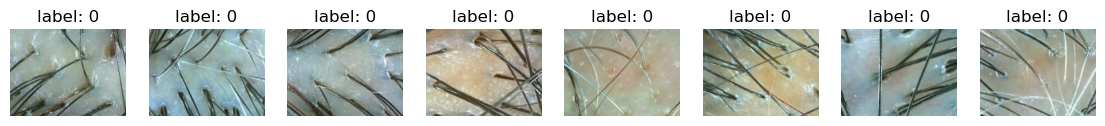

In [ ]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

n = 1
plt.figure(figsize=(14, 6))
for i in train_all_normal_df['img_path'][:8]:
  plt.subplot(int(str(18) + str(n)))
  img = cv2.imread(i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.title('label: 0')
  plt.axis('off')
  n += 1
plt.show()


## test_df 살펴보기
- val 폴더 내 폴더에서 150개씩 추출하여 shuffle

In [ ]:
from glob import glob   # glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환
tmp_test_normal = glob('./val/normal/'+ '*.jpg')[:150]
tmp_test_anomaly = glob('./val/seborrhea/'+ '*.jpg')[:150]

test_path = tmp_test_normal + tmp_test_anomaly

test_df = pd.DataFrame({'img_path' : test_path, 'label': [0 if 'normal' in i.split('/')[2] else 1 for i in test_path]})
test_df = test_df.sample(frac=1).reset_index(drop=True)   #shuffle
test_df

,img_path,label
0,./val/seborrhea\0643_A2LEBJJDE00048F_160690178...,1
1,./val/normal\8814_A2LEBJJDE00118S_160307205197...,0
2,./val/normal\8896_A2LEBJJDE001807_160611412229...,0
3,./val/normal\8833_A2LEBJJDE00156I_160603860572...,0
4,./val/seborrhea\1221_A1LCAIHDH00009X_160765185...,1
...,...,...
295,./val/seborrhea\0715_A2LEBJJDE00175D_160670713...,1
296,./val/seborrhea\2479_A2LEBJJDE00147H_160766133...,1
297,./val/normal\7027_A2LEBJJDE001117_160395296986...,0
298,./val/seborrhea\0643_A2LEBJJDE00048F_160671124...,1


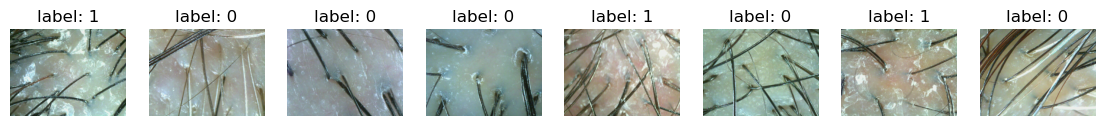

In [ ]:
# 테스트 데이터
n = 1
plt.figure(figsize=(14, 6))
for i in test_df['img_path'][:8]:
  plt.subplot(int(str(18) + str(n)))
  img = cv2.imread(i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.title('label: '+ str(test_df.loc[test_df['img_path'] == i, 'label'].item()))
  plt.axis('off')
  n += 1
plt.show()

## Test data에서 label 비율

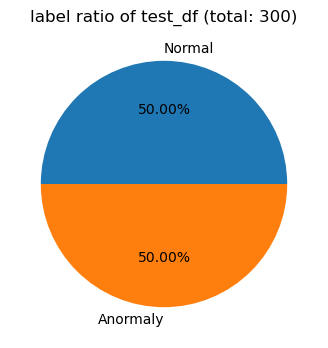

In [ ]:
import seaborn as sns
labels = ['Normal', 'Anormaly']
plt.figure(figsize=(4, 4))
test_label = test_df.groupby('label').count()
plt.pie(test_label['img_path'], labels= labels, autopct='%1.2f%%')
plt.title('label ratio of test_df (total: 300)')
plt.show()

## Image shape

In [ ]:
img = cv2.imread(train_all_normal_df['img_path'][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img.shape

(480, 640, 3)

## 이미지 전처리

In [ ]:
def noisy(img, noise_type="gauss"):
    '''
    ### Adding Noise ###
    img: image
    cj_type: {gauss: gaussian, sp: salt & pepper}
    '''
    if noise_type == "gauss":
        image=img.copy()
        mean=0
        st=0.7
        gauss = np.random.normal(mean,st,image.shape)
        gauss = gauss.astype('uint8')
        image = cv2.add(image,gauss)
        return image

    elif noise_type == "sp":
        image=img.copy()
        prob = 0.05
        if len(image.shape) == 2:
            black = 0
            white = 255
        else:
            colorspace = image.shape[2]
            if colorspace == 3:  # RGB
                black = np.array([0, 0, 0], dtype='uint8')
                white = np.array([255, 255, 255], dtype='uint8')
            else:  # RGBA
                black = np.array([0, 0, 0, 255], dtype='uint8')
                white = np.array([255, 255, 255, 255], dtype='uint8')
        probs = np.random.random(image.shape[:2])
        image[probs < (prob / 2)] = black
        image[probs > 1 - (prob / 2)] = white
        return image

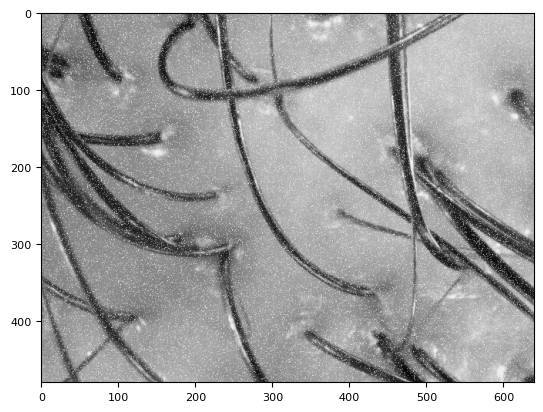

In [ ]:
img = cv2.imread(train_all_normal_df['img_path'][116])
img = noisy(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')

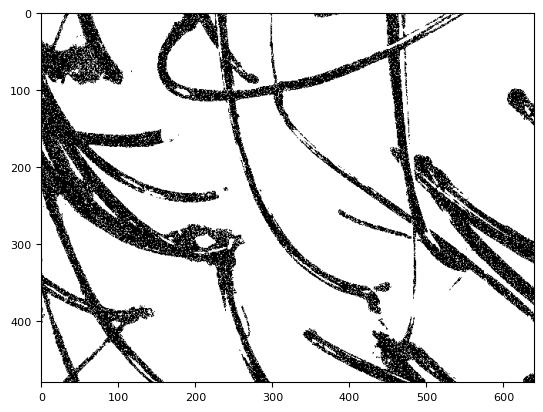

135.0


In [ ]:
th, img = cv2.threshold(img, 188, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(img, cmap='gray')
plt.show()

print(th)

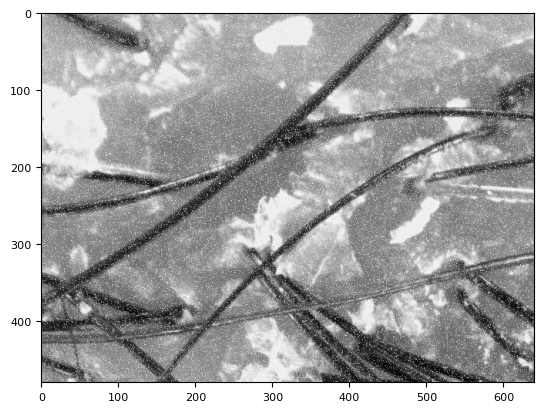

In [ ]:
img = cv2.imread(test_df['img_path'][10])
img = noisy(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray')
plt.show()

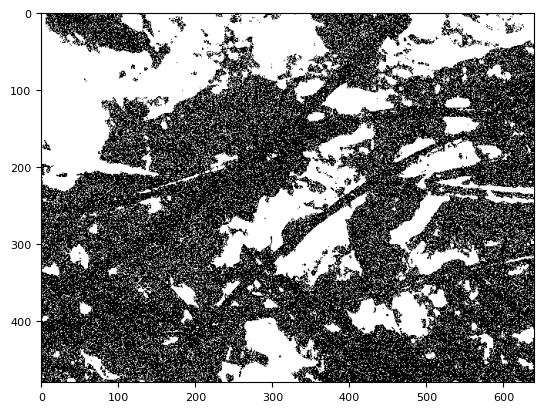

171.0


In [ ]:
img = noisy(img)
th, img = cv2.threshold(img, 188, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(img, cmap='gray')
plt.show()

print(th)

In [ ]:
img.shape

(480, 640)

In [ ]:
# 흑백 이미지를 3채널로 확장
expanded_image = np.repeat(img[np.newaxis, :, :], 3, axis=0)
expanded_image.shape

# ndarray를 이미지로 변환
# expanded_image = Image.fromarray(expanded_image)
expanded_image = np.transpose(expanded_image, (1, 2, 0))
expanded_image = Image.fromarray(expanded_image)
expanded_image

## Dataloader

In [ ]:
#데이터 로더로 데이터 불러오기
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        super(Dataset, self).__init__()
        self.df = df
        self.transform = transform

    #데이터셋의 길이 출력
    def __len__(self):
        return len(self.df)

    #인덱스를 입력하면 해당 인덱스에 해당하는 데이터 샘플을 파싱해서 이미지로 만듦
    def __getitem__(self, idx):
        img_path = self.df['img_path'].iloc[idx]
        image = cv2.imread(img_path)
        image = noisy(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, image = cv2.threshold(image, 188, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        # 흑백 이미지를 3채널로 확장
        expanded_image = np.repeat(image[np.newaxis, :, :], 3, axis=0)
        expanded_image = np.transpose(expanded_image, (1, 2, 0))

        # ndarray를 이미지로 변환
        expanded_image = Image.fromarray(expanded_image)


        if self.transform:
            expanded_image = self.transform(expanded_image)

        return expanded_image

In [ ]:
# 이미지 전처리 및 임베딩

transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_data = CustomDataset(df=train_all_normal_df, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [ ]:
next(iter(train_loader)).shape

torch.Size([32, 3, 456, 456])

## 특징 추출(Export Embedding Vector) - EfficientNet

모델의 마지막 레이어(일반적으로 분류를 위한 레이어)를 제거하여 모델의 출력이 마지막 분류 레이어 전의 특성 맵이 되도록 합니다. 이를 통해 각 이미지의 특성을 나타내는 임베딩 벡터를 얻을 수 있습니다.

- resnet50: https://colab.research.google.com/drive/1S3IwcLEhfWM6Pddk2KRrKd14U1OKsgjZ#scrollTo=to_-ImVt_Rhu

- FCN: https://velog.io/@kimkj38/%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-FCN-Fully-Convolutional-Networks-for-Semantic-Segmentation

- EfficientNet: https://keep-steady.tistory.com/35, https://startnow95.tistory.com/4

In [ ]:
# !pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

참고) model을 transfer-learning으로 학습해보자
EfficientNet은 ImageNet에 맞춰 학습되있으므로 마지막 출력 차원이 1000차원이다. 1000개 중 한개를 고르는 식.

내가 customize해서 모델을 구성할 땐 출력차원을 조정해줘야 한다. 모델은 2단계로 나뉜다.

1. CNN을 이용한 특징(feature) 추출(이미지 -> 특징, [1, 3, 224, 224] -> [1, 1280, 7, 7])

2. 특징(feature)을 이용하여 Linear-layer 후 Softmax로 분류(1, 1280, 7, 7) -> (1, 1000)

특징 추출만 한다면, 1단계를 가져와볼까?
이 중 전이학습을 하려면 2단계를 내 입맛에 맞게 바꾼다. Softmax 출력을 분류하려는 class 수로 바꾸자

In [ ]:
# EfficientNet 모델 불러오기
class MyEfficientNet(torch.nn.Module):
    def __init__(self, model):
        super(MyEfficientNet, self).__init__()
        # 원래 모델의 분류기를 제거
        self.features = model.extract_features
    def forward(self, x):
        # 원래 모델의 forward 함수를 사용하여 x를 변환
        x = self.features(x)
        return x

# EfficientNet 모델 로드 (사전 학습된 가중치 포함)
original_model = EfficientNet.from_pretrained('efficientnet-b5')
original_model.to(device)
original_model.eval()

# 새로운 모델 생성
model = MyEfficientNet(original_model)

# 모델을 평가 모드로 설정
model.to(device)
model.eval()

Loaded pretrained weights for efficientnet-b5


MyEfficientNet()

In [ ]:
# 특성 추출을 위한 함수 정의
def get_embeddings(model, dataloader):
    features = []
    with torch.no_grad():
        for inputs in tqdm(dataloader):
            expanded_inputs = inputs.to(device)
            features.append(model(expanded_inputs).detach().cpu().numpy())

    return np.concatenate(features)

train_embeddings = get_embeddings(model, train_loader)

100%|██████████| 17/17 [10:13<00:00, 36.06s/it]


In [ ]:
train_embeddings.shape

(534, 2048, 15, 15)

## 이상 탐지 Anomaly Detection Model Fitting

- one class svm : OneClassSVM expected <= dim 2.

In [ ]:
train_features_flat = train_embeddings.reshape(train_embeddings.shape[0], -1)
train_features_flat.shape

(534, 460800)

In [ ]:
from sklearn import svm

# One-Class SVM 모델 초기화
ocsvm = svm.OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)  # nu는 이상치 비율을 나타냄

# 모델 훈련 (정상 데이터만 사용)
ocsvm.fit(train_features_flat)

OneClassSVM(gamma='auto', nu=0.1)

## 성능 평가

- 결정 경계 : 분류 모델에서 클래스를 나누는 선, 평면 또는 경계를 의미하며 모델이 학습한 데이터를 기반으로 클래스 간의 구분을 담당
- 본 프로젝트와 같은 이상, 정상을 위한 이진 분류에서 결정 경계는 두 클래스를 나누는 선을 의미
- 결정 함수(Decision Function) : One-Class SVM 모델에서 사용되는 함수로, 새로운 데이터 포인트가 모델이 학습한 정상적인 데이터 분포에서 멀리 떨어져 있는지를 측정
- 이 함수는 각 데이터 포인트에서 결정 경계까지의 거리를 계산하고, 이 거리를 기반으로 해당 데이터 포인트를 정상 데이터로 간주할지 이상치로 간주할지를 결정
- 결정 함수의 값이 양수이면 해당 데이터 포인트는 정상으로 분류되며, 음수이면 이상치로 분류

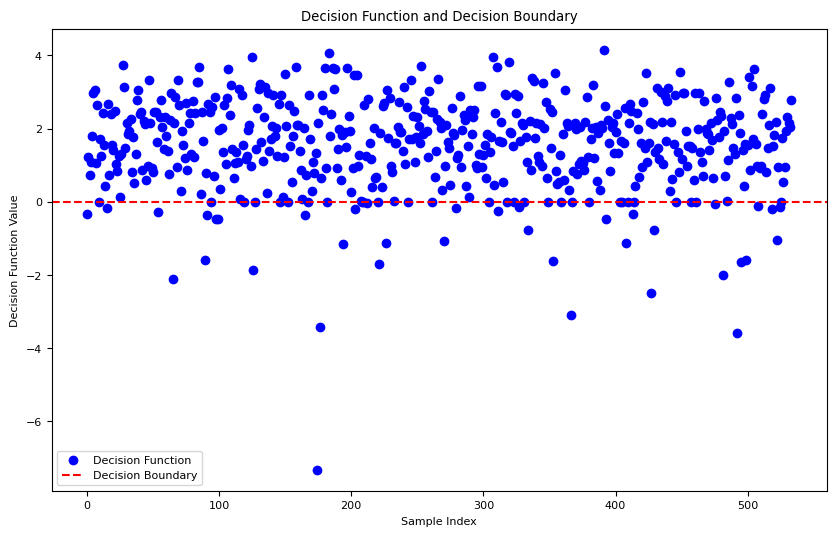

In [ ]:
# 정상적인 데이터의 특성을 기반으로 한 decision_function 결정 함수 값 계산
decision_values = ocsvm.decision_function(train_features_flat)

# 결정 함수 값과 결정 경계 시각화
plt.figure(figsize=(10, 6))
plt.scatter(range(len(decision_values)), decision_values, c='b', label='Decision Function')
plt.axhline(0, color='r', linestyle='--', label='Decision Boundary')
plt.xlabel('Sample Index')
plt.ylabel('Decision Function Value')
plt.title('Decision Function and Decision Boundary')
plt.legend()
plt.show()

## train 확인
- precision : 모델이 True라고 분류한 것 중에서 실제 True인 것의 비율
- recall : 실제 True인 것 중에서 모델이 True라고 예측한 것의 비율

In [ ]:
# 트레인 데이터에 대해 탐지 수행
train_pred = ocsvm.predict(train_features_flat)

# 예측 결과(이상 = -1, 정상 = 1)를 이상 = 1, 정상 = 0으로 변환
train_pred = np.where(train_pred == -1, 1, 0)
train_pred.sum()

52

In [ ]:
# 스코어 출력

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def get_clf_evalscore(y_test, pred):
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    pre = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    # auc = roc_auc_score(y_test, pred_proba[:,1])   isolation forest는 아웃라이어 평가하는데 확률을 사용하지 않기 때문에 pred_proba 없음

    # return acc, pre, rec, f1, auc
    print('Accuracy: {0:.4f}, Precision: {1:.4f}'.format(acc, pre))
    print('Recall: {0:.4f}, F1: {1:.4f}'.format(rec, f1))

In [ ]:
y_train = [0] * len(train_data)
len(y_train)

534

In [ ]:
get_clf_evalscore(y_train, train_pred)

Accuracy: 0.9026, Precision: 0.0000
Recall: 0.0000, F1: 0.0000


c:\Users\user\miniconda3\envs\ds_study\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


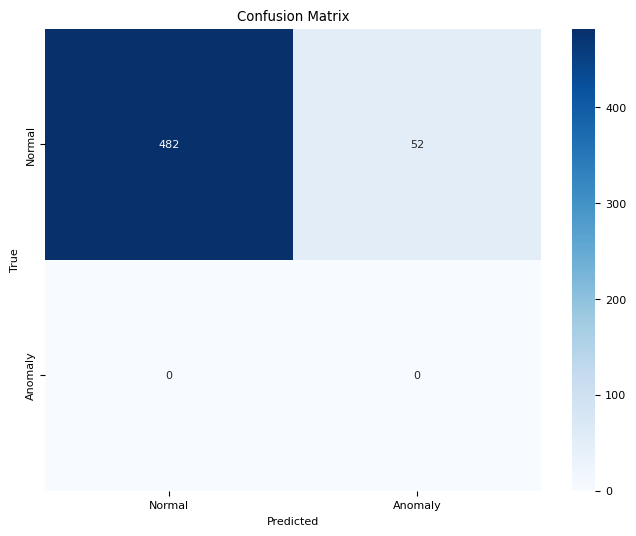

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix 계산
cm = confusion_matrix(y_train, train_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## 결과 예측

In [ ]:
# 테스트 데이터에 대해 이상 탐지 수행
test_data = CustomDataset(df=test_df, transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

test_embeddings = get_embeddings(model, test_loader)
test_features_flat = test_embeddings.reshape(test_embeddings.shape[0], -1)
test_pred = ocsvm.predict(test_features_flat)

# Isolation Forest의 예측 결과(이상 = -1, 정상 = 1)를 이상 = 1, 정상 = 0으로 변환
test_pred = np.where(test_pred == -1, 1, 0)

100%|██████████| 10/10 [05:48<00:00, 34.80s/it]


In [ ]:
test_pred.sum()

52

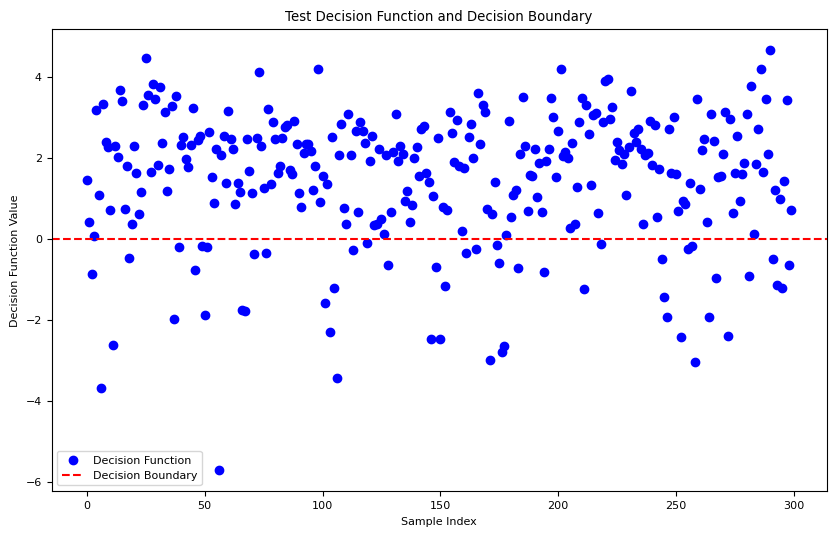

In [ ]:
# 정상적인 데이터의 특성을 기반으로 한 decision_function 결정 함수 값 계산
test_decision_values = ocsvm.decision_function(test_features_flat)

# 결정 함수 값과 결정 경계 시각화
plt.figure(figsize=(10, 6))
plt.scatter(range(len(test_decision_values)), test_decision_values, c='b', label='Decision Function')
plt.axhline(0, color='r', linestyle='--', label='Decision Boundary')
plt.xlabel('Sample Index')
plt.ylabel('Decision Function Value')
plt.title('Test Decision Function and Decision Boundary')
plt.legend()
plt.show()

In [ ]:
y_test = test_df['label']

get_clf_evalscore(y_test, test_pred)

Accuracy: 0.5533, Precision: 0.6538
Recall: 0.2267, F1: 0.3366


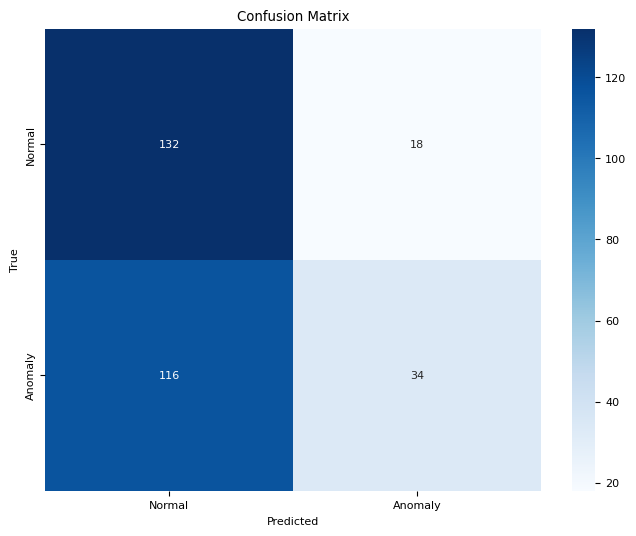

In [ ]:
# Confusion Matrix 계산
test_cm = confusion_matrix(y_test, test_pred)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
test_df['predict'] = test_pred
test_df

,img_path,label,predict
0,./val/seborrhea\0643_A2LEBJJDE00048F_160690178...,1,0
1,./val/normal\8814_A2LEBJJDE00118S_160307205197...,0,0
2,./val/normal\8896_A2LEBJJDE001807_160611412229...,0,1
3,./val/normal\8833_A2LEBJJDE00156I_160603860572...,0,0
4,./val/seborrhea\1221_A1LCAIHDH00009X_160765185...,1,0
...,...,...,...
295,./val/seborrhea\0715_A2LEBJJDE00175D_160670713...,1,1
296,./val/seborrhea\2479_A2LEBJJDE00147H_160766133...,1,0
297,./val/normal\7027_A2LEBJJDE001117_160395296986...,0,0
298,./val/seborrhea\0643_A2LEBJJDE00048F_160671124...,1,1


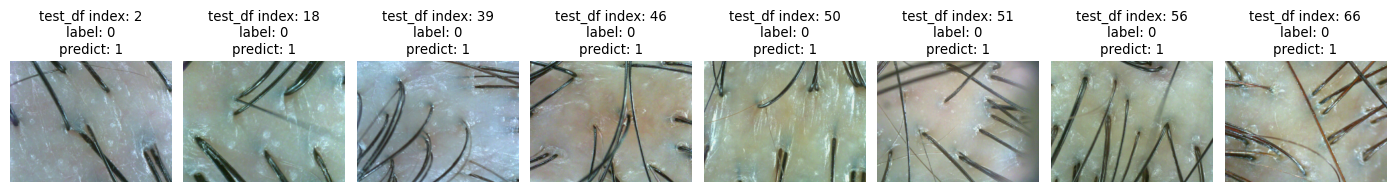

In [ ]:
# 0인데 1이라고 예측한 이미지들
plt.figure(figsize=(14, 6))
for i in range(8):
    tmp_df = test_df.loc[test_df['label'] < test_df['predict'], 'img_path']
    tmp_img = tmp_df.iloc[i]
    plt.subplot(int(str(18) + str(i+1)))
    tmp_img = Image.open(tmp_img)
    plt.imshow(tmp_img)
    plt.title(f'test_df index: {tmp_df.index[i]}\nlabel: 0\npredict: 1')
    plt.rc('font', size=8)
    plt.axis('off')

plt.tight_layout()
plt.show()


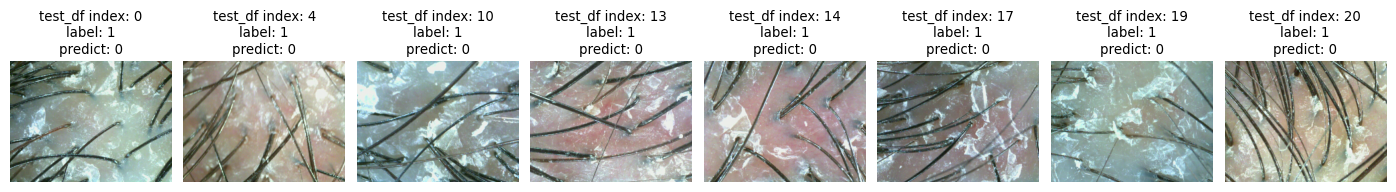

In [ ]:
# 1인데 0이라고 예측한 이미지들
plt.figure(figsize=(14, 6))
for i in range(8):
    tmp_df = test_df.loc[test_df['label'] > test_df['predict'], 'img_path']
    tmp_img = tmp_df.iloc[i]
    plt.subplot(int(str(18) + str(i+1)))
    tmp_img = Image.open(tmp_img)
    plt.imshow(tmp_img)
    plt.title(f'test_df index: {tmp_df.index[i]}\nlabel: 1\npredict: 0')
    plt.rc('font', size=8)
    plt.axis('off')

plt.tight_layout()
plt.show()